# Automated decline curve analysis with Python

In [1]:
# Importing Python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.optimize import curve_fit

In [221]:
# Loading the monthly oil production dataset
filepath = 'oilprod.csv'
df = pd.read_csv(filepath, delimiter=';', index_col='Well')
df.head()

,Date,Oil Rate (bopd),Cum oil (bbls)
Well,,,
AD-08,01/07/2011,194.91,6042.16
AD-08,01/08/2011,1091.95,39892.50
AD-08,01/09/2011,1093.43,72695.30
AD-08,01/10/2011,1085.19,106336.19
AD-08,01/11/2011,931.46,134280.05


In [222]:
# convert date string to Panda datetime format
df['Date'] =  pd.to_datetime(df['Date'], format='%d/%m/%Y') 

# display the data
df

,Date,Oil Rate (bopd),Cum oil (bbls)
Well,,,
AD-08,2011-07-01,194.91,6042.16
AD-08,2011-08-01,1091.95,39892.50
AD-08,2011-09-01,1093.43,72695.30
AD-08,2011-10-01,1085.19,106336.19
AD-08,2011-11-01,931.46,134280.05
...,...,...,...
ADR8-8,2016-07-01,0.00,167456.02
ADR8-8,2016-08-01,0.00,167456.02
ADR8-8,2016-09-01,68.32,169505.71


In [175]:
df.describe(include='all', datetime_is_numeric=True)

,Date,Oil Rate (bopd),Cum oil (bbls)
count,11039,11039.000000,1.103900e+04
mean,2014-09-04 07:05:23.181447680,724.348748,5.924393e+05
min,2011-06-01 00:00:00,0.000000,0.000000e+00
25%,2013-08-01 00:00:00,260.160000,2.080915e+05
50%,2014-11-01 00:00:00,641.930000,4.798114e+05
75%,2015-12-01 00:00:00,1112.695000,8.698910e+05
max,2016-11-01 00:00:00,3293.560000,2.735195e+06
std,NaN,575.460346,4.819702e+05


In [223]:
Wells = df.index.unique().tolist()

In [224]:
# function for hyperbolic decline
def hyperbolic(t, qi, di, b):
    return qi / (1 + b * di * t)**(1/b)

In [225]:
# function for hyperbolic cumulative production
def cumpro(q_forecast, qi, di, b):
    return (((qi**b) / ((1 - b) * di)) * ((qi ** (1 - b)) - (q_forecast ** (1 - b)))) 

In [226]:
df['qo_DCA (bopd)'] = 0
df['Np_DCA (bbls)'] = 0

In [227]:
Wells[:30]

['AD-08',
 'AD-09',
 'AD-1',
 'AD-104H',
 'AD-10H',
 'AD-11',
 'AD1-10-1H',
 'AD1-10-2H',
 'AD1-10-3H',
 'AD1-10-4H',
 'AD1-10-5H',
 'AD1-11-1H',
 'AD1-11-2H',
 'AD1-11-3H',
 'AD1-11-4H',
 'AD1-11-5H',
 'AD1-11-6H',
 'AD1-11-7H',
 'AD1-1-1H',
 'AD1-12-1H',
 'AD1-12-2H',
 'AD1-12-3H',
 'AD1-12-4H',
 'AD1-12-5H',
 'AD1-12-6H',
 'AD1-12-7H',
 'AD1-12-8H',
 'AD1-1-2H',
 'AD1-13-1H',
 'AD1-13-2H']

In [244]:
%%time
qis = []
dis = []
bs = []
for well in Wells[:50]:
    T = (df.loc[well,'Date'] - df.loc[well,'Date'].min())/datetime.timedelta(days=1)
    q = df.loc[well, 'Oil Rate (bopd)']
    # fitting the data with the hyperbolic function
    popt, pcov = curve_fit(hyperbolic, T, q, bounds=([0, 0, 0], [10000, 0.01, 1]))
    qi, di, b = popt
    df.loc[well,'qo_DCA (bopd)'] = hyperbolic(T, qi, di, b)
    df.loc[well,'Np_DCA (bbls)'] = cumpro(df.loc[well,'qo_DCA (bopd)'], qi, di, b)
    qis.append(np.round(qi,2))
    dis.append(np.round(di,5))
    bs.append(np.round(b, 3))
DCA_parameters = pd.DataFrame({'Qi': qis, 'Di': dis,'b': bs}, index=Wells[:50])

Wall time: 3.13 s


In [245]:
DCA_parameters

,Qi,Di,b
AD-08,1197.14,0.00058,0.000
AD-09,121.22,0.00000,0.250
AD-1,919.24,0.00119,0.000
AD-104H,99.17,0.01000,0.000
AD-10H,1538.60,0.00147,0.171
AD-11,921.09,0.00048,0.000
AD1-10-1H,1587.53,0.00259,0.000
AD1-10-2H,1660.57,0.00092,0.000
AD1-10-3H,220.13,0.00000,0.748
AD1-10-4H,1044.59,0.00270,0.000


In [246]:
df.loc['AD1-13-6H']

,Date,Oil Rate (bopd),Cum oil (bbls),qo_DCA (bopd),Np_DCA (bbls)
Well,,,,,
AD1-13-6H,2014-02-01,841.60,23564.81,1355.853954,0.000000
AD1-13-6H,2014-03-01,1182.71,60228.94,1280.180365,36890.008362
AD1-13-6H,2014-04-01,1252.57,97806.03,1203.241176,75365.460685
AD1-13-6H,2014-05-01,1511.71,144669.07,1134.917124,110423.584566
AD1-13-6H,2014-06-01,1261.98,182528.55,1069.988079,144585.512892
AD1-13-6H,2014-07-01,1505.80,229208.37,1012.086172,175805.133446
AD1-13-6H,2014-08-01,875.29,256342.48,956.840836,206312.069194
AD1-13-6H,2014-09-01,1238.16,293487.24,905.801149,235172.704788
AD1-13-6H,2014-10-01,1185.28,330230.82,860.028792,261651.685556


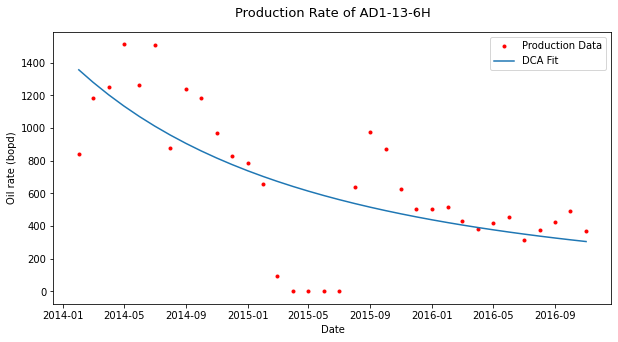

In [247]:
well = 'AD1-13-6H'
plt.figure(figsize=(10,5))
plt.plot(df.loc[well,'Date'], df.loc[well,'Oil Rate (bopd)'], '.', color='red', label='Production Data')
plt.plot(df.loc[well,'Date'], df.loc[well,'qo_DCA (bopd)'], label='DCA Fit')
plt.title('Production Rate of {}'.format(well), size=13, pad=15)
plt.xlabel('Date')
plt.ylabel('Oil rate (bopd)')
plt.legend()
plt.show()

In [239]:
print('Initial production rate:', DCA_parameters.loc[well, 'Qi'], 'bopd')
print('Initial decline rate (% per year):', DCA_parameters.loc[well, 'Di'] * 365.25 * 100, '%')
print('Decline coefficient:', DCA_parameters.loc[well, 'b'])

Initial production rate: 1355.85 bopd
Initial decline rate (% per year): 75.972 %
Decline coefficient: 0.427


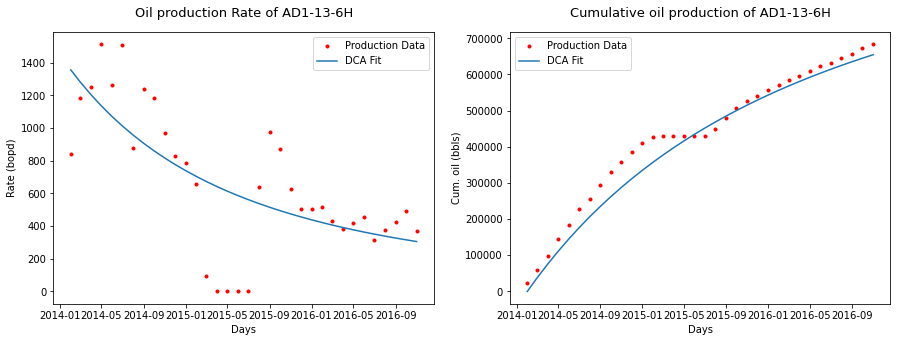

In [240]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(df.loc[well,'Date'], df.loc[well,'Oil Rate (bopd)'], '.', color='red', label='Production Data')
plt.plot(df.loc[well,'Date'], df.loc[well,'qo_DCA (bopd)'], label='DCA Fit')
plt.title('Oil production Rate of {}'.format(well), size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Rate (bopd)')
plt.legend()


plt.subplot(1,2,2)
plt.plot(df.loc[well,'Date'], df.loc[well,'Cum oil (bbls)'], '.', color='red', label='Production Data')
plt.plot(df.loc[well,'Date'], df.loc[well,'Np_DCA (bbls)'], label='DCA Fit')
plt.title('Cumulative oil production of {}'.format(well), size=13, pad=15)
plt.xlabel('Days')
plt.ylabel('Cum. oil (bbls)')
plt.legend()


plt.show()

In [241]:
df

,Date,Oil Rate (bopd),Cum oil (bbls),qo_DCA (bopd),Np_DCA (bbls)
Well,,,,,
AD-08,2011-07-01,194.91,6042.16,1197.136365,0.000000
AD-08,2011-08-01,1091.95,39892.50,1178.005576,32774.647399
AD-08,2011-09-01,1093.43,72695.30,1154.521434,73007.411524
AD-08,2011-10-01,1085.19,106336.19,1136.071652,104615.367001
AD-08,2011-11-01,931.46,134280.05,1113.423484,143415.949712
...,...,...,...,...,...
ADR8-8,2016-07-01,0.00,167456.02,0.000000,0.000000
ADR8-8,2016-08-01,0.00,167456.02,0.000000,0.000000
ADR8-8,2016-09-01,68.32,169505.71,0.000000,0.000000
